
# Circular Statistics
---

As far as I'm aware, most data analysts and statisticians don't often come across non-euclidean spaces. From my reading, it seems the majority of applications exist in the sciences, but I think the ideas are pretty approachable, especially for the circle topology ($\mathbb{S} ^1$,  called the "1-sphere". I'm going to use $\mathbb{S}$ throughout). So, I thought I'd describe how the basic statistics work on circles for my audience of precisely zero readers. The classic example scenario is that of wind direction measurements, which are bearings and so $\mathbb{R}$ is topologically unfit. What would the equivalent of a normal distribution on a circle be when wrapped around a circle? The integral for a chunk of normal distribution on $\mathbb{R}$ goes to near nothing as you move away from the mean, but on a circle, the furthest extreme away from the mean doesn't feel so out of reach...

I'll demonstrate how the basics like mean and variance work on $\mathbb{S}$, visualise some interesting geometry and algorithm stuff, then introduce the circle's equivalent of the normal distribution before a basic simulated example.

---




In [1]:
from circle_utilities import *

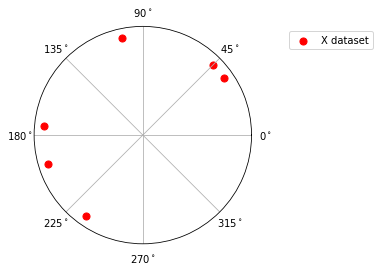

In [2]:

X = [45, 35, -185, 235, -258, 197]
draw_compass(X);


### Mean & Variance

The obvious problem is the disconnected nature of $[0^\circ, 360^\circ)$ - From a typical (euclidean) maths perspective, the average of 45 and 315 is 180, but in the context of bearings, that clearly isn't what we want - we would want 0; and the reflexive mod $2\pi$ isn't going to work in all scenarios:

Euclidean mean is 180, but we really want 0 / 360


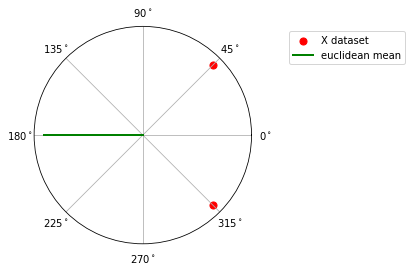

In [3]:
print("Euclidean mean is 180, but we really want 0 / 360")
draw_compass([45, 315], mean='euclidean');

Euclidean mean here is 472.5, corresponding to 112.5, which works:


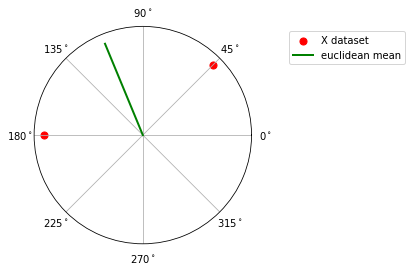

In [4]:
print("Euclidean mean here is 472.5, corresponding to 112.5, which works:")
draw_compass([405, 540], mean='euclidean');


But adding another point throws it off:


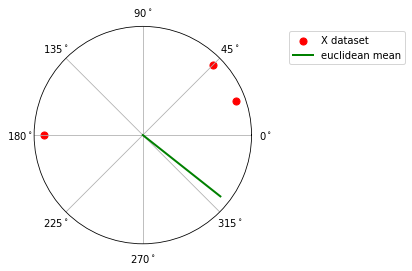

In [5]:
print("But adding another point throws it off:")
draw_compass([405, 540, 20], mean='euclidean');

### The External Mean 
In the first example, we want $45^\circ$ and $315^\circ$ to give a mean of $0^\circ$ If you haven't encountered circle stats before, your immediate thought, as was mine, was probably to think about the points as being embedded in $\mathbb{R}^2$, then project the average of those points onto $\mathbb{S}$. that actually works decently, perfectly so when you only have two points:

Something like: 
$$
\begin{align}
P_1 &= e^{\frac{\pi}{4}i}, P_2 = e^{-\frac{\pi}{4}i}\\
P_{avg} &= P_1 + P_2\\
&= 2\cos(\pi/4)\\
\hat{P_{avg}} &= 1  & (\text{Projecting it onto the circle})
\end{align}
$$

This lands on zero degrees. 


This solution is robust to wrapping around the discontinuity and it has a nice centre-of-mass physics intuition. The main critique to this approach is that the solution relies on ambient space $\mathbb{R}^2$ around it, which honestly feels a bit mid-curve, but hey, cool only exists across the valley of cringe. Since this mean is acquired by assuming and exploiting external surplus structure, it is called the **extrinsic mean**, but I use `'vec'` in my code. Let's try it on some points:

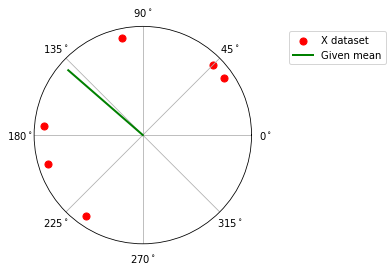

In [6]:
vector_sum_mean = circular_mean(X, method='vec')
draw_compass(X, vector_sum_mean);

Looks sensible, but... is it really in the middle?

### The Intrinsic Mean
The intrinsic mean is one which is defined entirely in-universe, and so it doesn't make reference to the ambient space around the circle. 

Let's see it on a set of points on the circle before investigating:

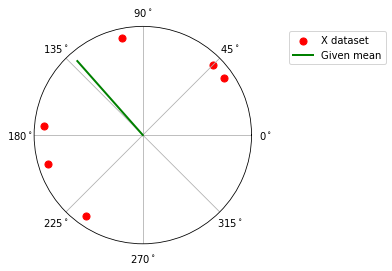

In [7]:
intrinsic_mean = circular_mean(X, method='optimize_intrinsic')
draw_compass(X, intrinsic_mean);

Not quite the same, but quite close. How as this intrinsic mean computed?

If you took the typical euclidean version of variance, but think about it like a function on a certain point in the context of a dataset...

$$
V(x^\star) = \sum_i (x_i - x^\star)^2
$$

... then minimized it, you would find that the lowest value occurs at the mean as typically defined. That is, you'd find $x^\star = \sum_i x_i p_i = \mathbb{E}(X)$.

It's backwards from the way we typically think about the two artefacts, but feels intuitive with a moment of thought. This perspective also provides an alternative strategy in defining the mean for our circular universe. Finding the point that minimises the squared distance from all the other points avoids having to eyeball whether it's in 'the middle', which is quite intellectual jouissance.

Using $d(\mu, x) := |\mu - x - 2\pi k|$ to measure the length of shortest arc distances, all sorts of nice, mathsy things we always love to have emerge like global, unique solutions etc, with one important caveat that the data isn't uniformly distributed across the circle. The mean we obtain this way is referred to as the **intrinsic mean** - intrinsic because it's defined entirely in the context of the circle's own geometry (This version of the mean doesn't rely on any structural support from $\mathbb{R}^2$).

$k$ is from $\{-1, 0, 1\}$ depending on where the bits and pieces land on $\mathbb{S}$.

In [20]:
mu = np.array([45, 90])
X = [45, 35, 175, 235, 102, 197]
print(V_n(mu, X))


[3.66825374 2.2791983 ]


There's some really interesting shape stuff that happens with this maths, and this isn't a useless detour since a nice, fast algo emerges from this for finding the solution to the $V(\mu)$ optimisation problem.

First, a visualisation of the $V(\mu)$ function relative to a random set of points:

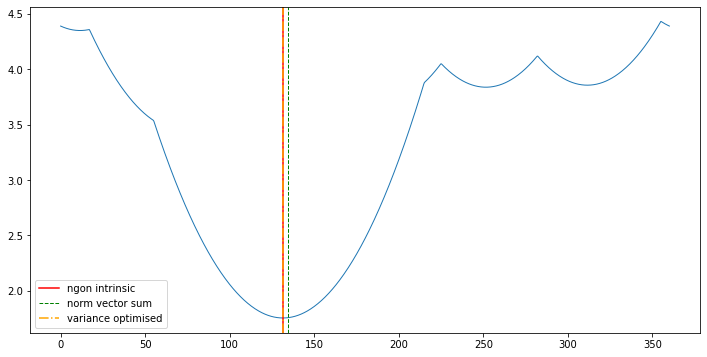

In [9]:
visualise_variance(X, indicate_polygon=False, indicate_mean=True)

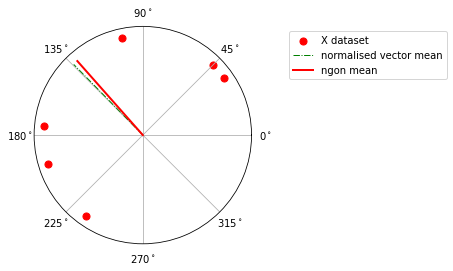

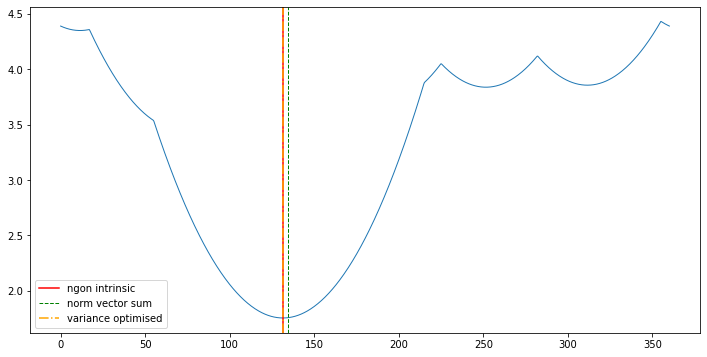

In [10]:
draw_compass(X, mean='circular'); visualise_variance(X)

Clearly the normalised vector sum doesn't necessarily align with the distance minimising mean. In this case, and i'm told by the llms that in most practical cases, the two means more or less coincide.

There's a third mean there which is derived from the fast algo I mentioned. More on that next.

358.3399807227031
343.6
[ 58  15 316  59 271  80 195 295  14 333]


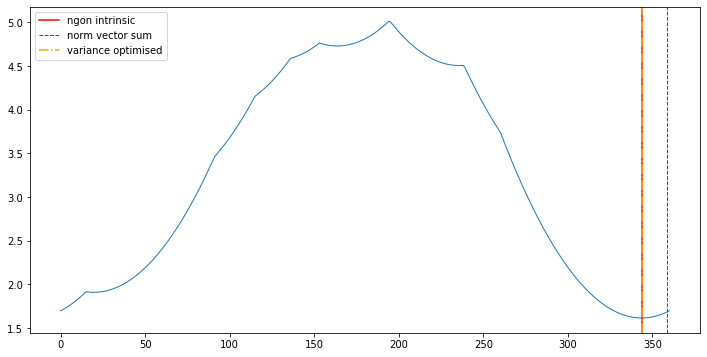

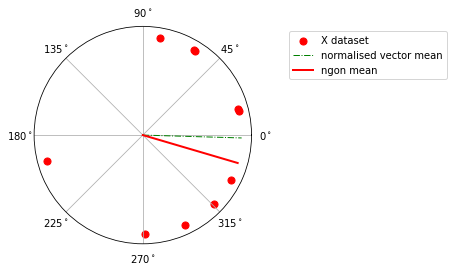

In [11]:
Y = np.random.randint(0, 360, 10)
# Y = np.array([ -61  117 -113  -23  -43 -135  159 -144  -28  150]) a nice set of values
print(circular_mean(Y, method='vec'))
print(circular_mean(Y, method='ngon_intrinsic'))
visualise_variance(Y), draw_compass(Y, mean='circular')
print(Y)

### The N-gon Mean

If you crunch through the maths you would discover some nice gometry and a very useful coincidence. The result itself is straightforward to derive. Here's the $\mu \ge 0$ part for demonstration:

$$
\begin{align}
V_n(\mu) &= \frac{1}{n} \big( \sum_{j=1}^i (X_j - \mu + 2\pi)^2 + \sum_{j=i+1}^n (X_j - \mu)^2 \big)\\
&= \frac{1}{n} \big( \sum_{j=i}^n (X_j - \mu)^2 - 4\pi \sum_{j=1+1}^n (\mu - X_j - \pi)\big)
\end{align}
$$

This optimises at: $\mu = \bar X + \frac{2\pi i}{n} \> \text{mod } 2\pi, i \in [0, 1, 2, ..., n-1]$ globally for one of the $i$'s

The potential solutions to the variance minimisation problem draw a regular polygon on the circle, and the euclidean mean ($i=0$) will coincide with a vertex of a regular polygon inscribed in the circle. This gives a really efficient method for finding the variance optimising $\mu$ - in one line, the algorithm is: Starting with the euclidean mean as the generator, get all the vertices of the n-gon where n is the size of the dataset and check the $V_n$ at each then pick the minimum:

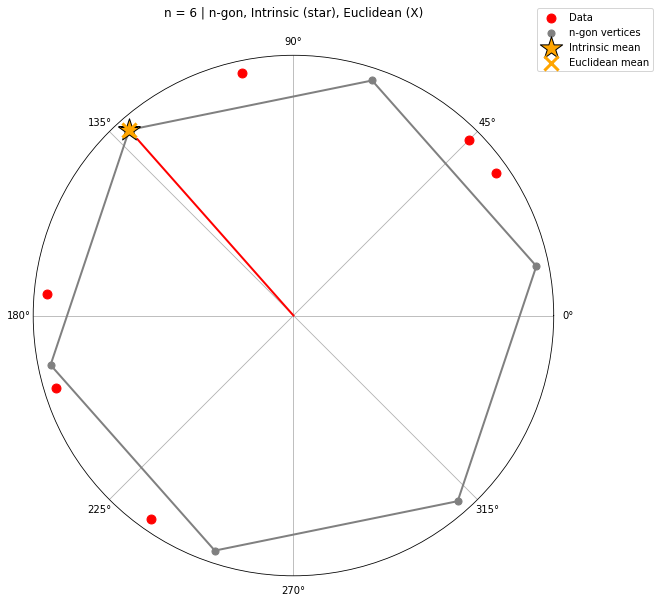

In [12]:
draw_ngon(X, mean_method='ngon_intrinsic');

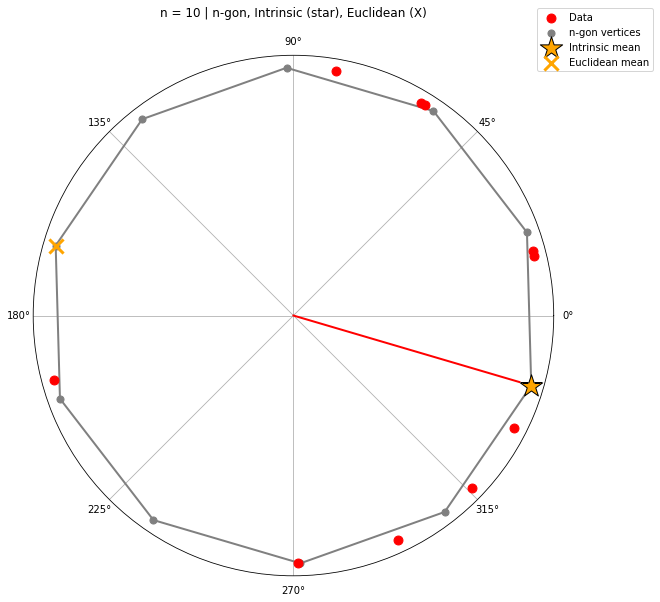

In [13]:
draw_ngon(Y, mean_method='ngon_intrinsic');

There's obviously all sorts of other weirdness about non euclidean topologies that i'm entirely dismissing for this casual bit of fun. In that spirit, a punchy conclusion to this piece would be a brief look at the Von Mises distribution, which is basically the circle's normal distribution.

### The Von Mises Distribution

$$
f(\theta; \mu, \kappa) = \frac{1}{2\pi I_0(\kappa)} \exp(\kappa \cos(\theta - \mu))
$$

- $\mu$: intrinsic mean
- $\kappa$: concentration (analogous to $1/\sigma^2$)  
- $I_0(\kappa)$: normalising constant - modified bessel function

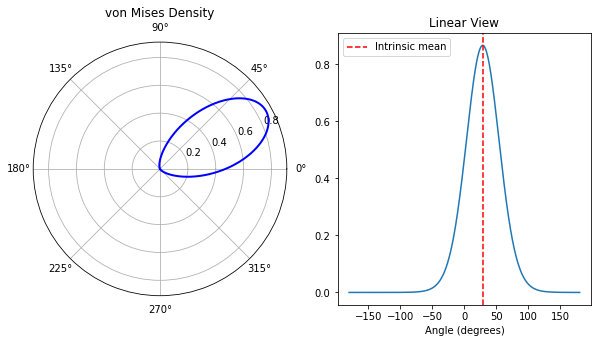

In [14]:
theta = np.linspace(-np.pi, np.pi, 1000)
kappa = 5
mu = 0.5
pdf = np.exp(kappa * np.cos(theta - mu)) / (2*np.pi * i0(kappa))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1, projection='polar')
plt.plot(theta, pdf, 'b-', lw=2)
plt.title('von Mises Density')

plt.subplot(1,2,2)
plt.plot(np.rad2deg(theta), pdf)
plt.axvline(np.rad2deg(mu), color='red', ls='--', label='Intrinsic mean')
plt.legend()
plt.xlabel('Angle (degrees)')
plt.title('Linear View')
plt.show()

### Basic Example

Suppose a simple robotic arm is identifying and grabbing objects that enter and exit the reach of its grippers. It has to choose what bearing to leave the arm at rest to minimise energy consumption and or time spent adjusting the arm's bearing. It updates its expectation with incoming data to make this decision. What's the chance that it has to pull a 'sharp turn' -  45 degrees or more?

In [18]:
np.random.seed(43)

# --- Dataset
N = 200
loc = np.random.rand() * np.pi
kappa = 8
sample = vonmises(loc=loc, kappa=kappa).rvs(N)
sharp = 0.25 * np.pi

# --- Fit VM
est_kappa, mu_radians, _ = vonmises.fit(sample, fscale=1)
mu_degrees = np.rad2deg(mu_radians) % 360
p_in_arc_of_interest = 2 * vonmises.sf(sharp, est_kappa)

print(f"True params: \n\tk: {kappa:.3f}, mu: {loc:.3f}")
print(f"Estimated params: \n\tk: {est_kappa:.3f}, mu: {mu_radians:.3f}")
print(f"Probability of being in arc: \n\t{p_in_arc_of_interest:.2f}", )

True params: 
	k: 8.000, mu: 0.361
Estimated params: 
	k: 8.135, mu: 0.328
Probability of being in arc: 
	0.03


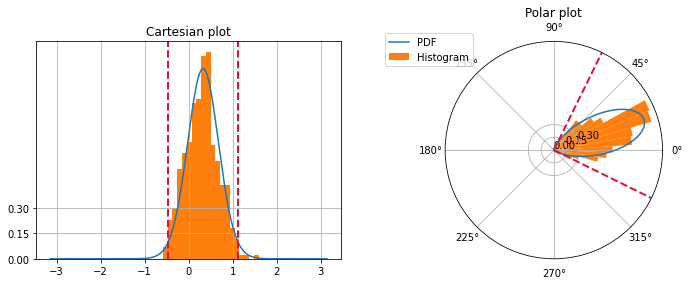

In [19]:
plot_vonmises(kappa=est_kappa, loc=mu_radians, sharp=np.pi*.25)

For completeness, here's a few different VMs with random choice of kappa and mu:

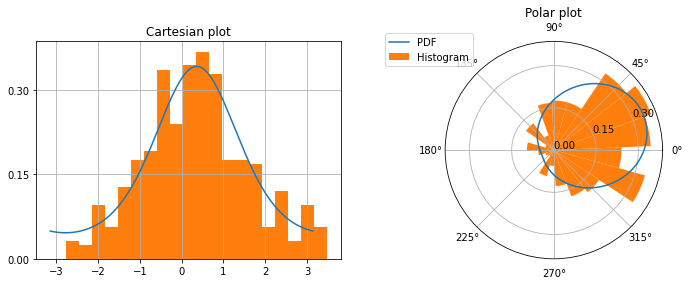

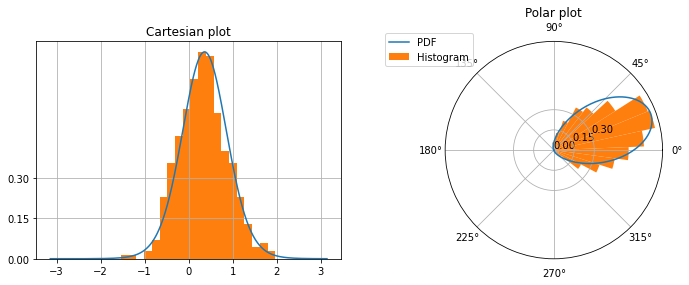

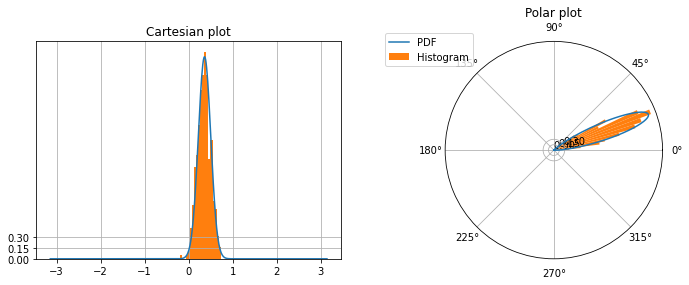

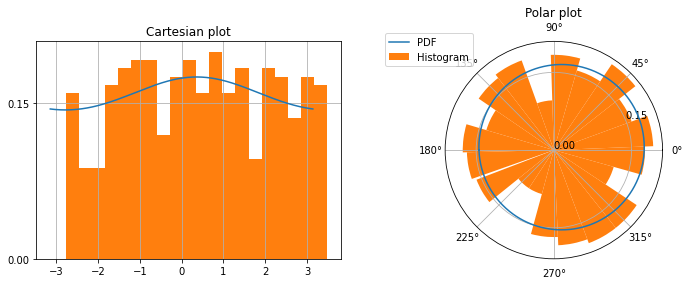

In [17]:
plot_vonmises(kappa=1)
plot_vonmises(kappa=4)
plot_vonmises(kappa=50)
plot_vonmises(kappa=0.1)